In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
# extract the raw dataset
# df = pd.read_csv('/content/drive/MyDrive/D-VA/Load Forecasting/Biotech_dataset.csv')

# extract the clean dataset
df = pd.read_csv('/content/drive/MyDrive/D-VA/Load Forecasting/Biotech_clean_dataset.csv')

In [ ]:
# Uncomment to extract pure numbers - no commas and units
# for col in df.columns:
#   if col == "Time":
#     continue
#   df[col] = df[col].astype(str)
#   df[col] = df[col].str.split().str[0]
#   df[col] = df[col].str.replace(',', '')
#   df[col] = pd.to_numeric(df[col])

In [ ]:
df

,Time,Total (W),Phase_A (W),Phase_B (W),Phase_C (W)
0,1/4/2024 15:00,821,207,467,147
1,1/4/2024 16:00,741,298,329,114
2,1/4/2024 17:00,776,363,278,135
3,1/4/2024 18:00,1260,659,419,182
4,1/4/2024 19:00,973,381,410,182
...,...,...,...,...,...
4809,7/8/2024 5:00,1040,635,259,146
4810,7/8/2024 6:00,1414,1023,251,140
4811,7/8/2024 7:00,571,225,243,103
4812,7/8/2024 8:00,784,411,280,93


In [ ]:
# Extract raw dataset from clean dataset
# df.to_csv('Biotech_clean_dataset.csv', index=False)

In [ ]:
# To keep it simple, we will predict only on the total active power first
df_total = df.drop(['Phase_A (W)', 'Phase_B (W)', 'Phase_C (W)'], axis=1)

In [ ]:
df_total

,Time,Total (W)
0,1/4/2024 15:00,821
1,1/4/2024 16:00,741
2,1/4/2024 17:00,776
3,1/4/2024 18:00,1260
4,1/4/2024 19:00,973
...,...,...
4809,7/8/2024 5:00,1040
4810,7/8/2024 6:00,1414
4811,7/8/2024 7:00,571
4812,7/8/2024 8:00,784


In [ ]:
# set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
# Convert 'Time' column from string to datetime format
df_total['Time'] = pd.to_datetime(df_total['Time'])

In [ ]:
df_total

,Time,Total (W)
0,2024-01-04 15:00:00,821
1,2024-01-04 16:00:00,741
2,2024-01-04 17:00:00,776
3,2024-01-04 18:00:00,1260
4,2024-01-04 19:00:00,973
...,...,...
4809,2024-07-08 05:00:00,1040
4810,2024-07-08 06:00:00,1414
4811,2024-07-08 07:00:00,571
4812,2024-07-08 08:00:00,784


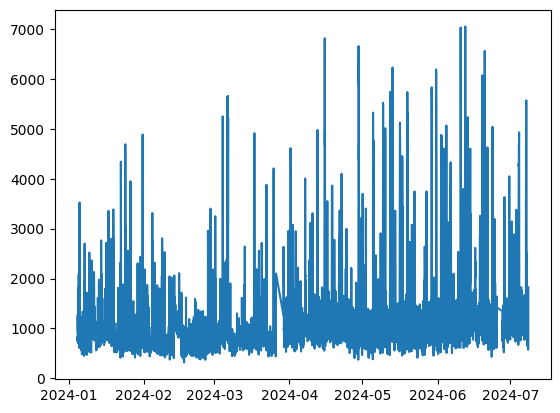

In [ ]:
plt.plot(df_total['Time'], df_total['Total (W)'])
plt.show()

In [ ]:
# total number of missing values
df_total.isna().sum()

Time         0
Total (W)    0
dtype: int64

In [ ]:
# find duplicaates
# df_total.duplicated().sum()
# duplicates = df_total.duplicated()
# duplicate_indices = duplicates[duplicates].index
# duplicate_indices

In [ ]:
df_total

,Time,Total (W)
0,2024-01-04 15:00:00,821
1,2024-01-04 16:00:00,741
2,2024-01-04 17:00:00,776
3,2024-01-04 18:00:00,1260
4,2024-01-04 19:00:00,973
...,...,...
4809,2024-07-08 05:00:00,1040
4810,2024-07-08 06:00:00,1414
4811,2024-07-08 07:00:00,571
4812,2024-07-08 08:00:00,784


In [ ]:
def prepare_df(df, n_steps: int):
  df = dc(df)
  df.set_index('Time', inplace=True)

  for i in range(1, n_steps+1):
    df[f'Power[t-{i}] (W)'] = df['Total (W)'].shift(i)
  df.dropna(inplace=True)
  return df

lookback = 6
shifted_df = prepare_df(df_total, lookback)
shifted_df


,Total (W),Power[t-1] (W),Power[t-2] (W),Power[t-3] (W),Power[t-4] (W),Power[t-5] (W),Power[t-6] (W)
Time,,,,,,,
2024-01-04 21:00:00,1812,929.0,973.0,1260.0,776.0,741.0,821.0
2024-01-04 22:00:00,715,1812.0,929.0,973.0,1260.0,776.0,741.0
2024-01-04 23:00:00,959,715.0,1812.0,929.0,973.0,1260.0,776.0
2024-01-05 00:00:00,834,959.0,715.0,1812.0,929.0,973.0,1260.0
2024-01-05 01:00:00,694,834.0,959.0,715.0,1812.0,929.0,973.0
...,...,...,...,...,...,...,...
2024-07-08 05:00:00,1040,645.0,1288.0,1200.0,827.0,934.0,1358.0
2024-07-08 06:00:00,1414,1040.0,645.0,1288.0,1200.0,827.0,934.0
2024-07-08 07:00:00,571,1414.0,1040.0,645.0,1288.0,1200.0,827.0


In [ ]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np.shape

(4808, 7)

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.55595132, -0.8180469 , -0.80498664, ..., -0.86346097,
        -0.87384981, -0.85010389],
       [-0.88156723, -0.55595132, -0.8180469 , ..., -0.71979816,
        -0.86346097, -0.87384981],
       [-0.80914218, -0.88156723, -0.55595132, ..., -0.80498664,
        -0.71979816, -0.86346097],
       ...,
       [-0.92430988, -0.67408727, -0.78509944, ..., -0.71148709,
        -0.7376076 , -0.84832294],
       [-0.86108638, -0.92430988, -0.67408727, ..., -0.90234491,
        -0.71148709, -0.7376076 ],
       [-0.55238943, -0.86108638, -0.92430988, ..., -0.78509944,
        -0.90234491, -0.71148709]])

In [87]:
# separate features from labels
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((4808, 6), (4808,))

In [88]:
# flip the columns so that t-1 is the latest column and t-lookback is the last column
X = dc(np.flip(X, axis=1))
X

array([[-0.85010389, -0.87384981, -0.86346097, -0.71979816, -0.80498664,
        -0.8180469 ],
       [-0.87384981, -0.86346097, -0.71979816, -0.80498664, -0.8180469 ,
        -0.55595132],
       [-0.86346097, -0.71979816, -0.80498664, -0.8180469 , -0.55595132,
        -0.88156723],
       ...,
       [-0.84832294, -0.7376076 , -0.71148709, -0.90234491, -0.78509944,
        -0.67408727],
       [-0.7376076 , -0.71148709, -0.90234491, -0.78509944, -0.67408727,
        -0.92430988],
       [-0.71148709, -0.90234491, -0.78509944, -0.67408727, -0.92430988,
        -0.86108638]])

In [89]:
# set the split index to separate training data and test data
split_index = int(len(X) * 0.8)
split_index


3846

In [90]:
# separate the training and test datasets
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3846, 6), (962, 6), (3846,), (962,))

In [91]:
# convert numpy into tensors to work with pytorch
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3846, 6]),
 torch.Size([962, 6]),
 torch.Size([3846]),
 torch.Size([962]))

In [95]:
# torch dataset
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [96]:
# torch dataloader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [97]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break


torch.Size([32, 6]) torch.Size([32])


In [98]:
# LSTM model
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1,4,1)
model.to(device)
model



LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [99]:
def train_one_epoch():
  model.train(True)
  print(f"Epoch: {epoch+1}")
  running_loss = 0.0
  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99:
      avg_loss_across_batches = running_loss/100
      print(f"Batch {batch_index+1} loss: {avg_loss_across_batches}")
      running_loss = 0.0

    print()


In [100]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [101]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors